In [1]:
# created by Swain, 2017-12-14, 20:47

import math
import numpy
import matplotlib.pyplot as plot
from numpy import random
from sklearn.datasets import load_svmlight_file

#load a9a dataset
#training dataset
data = load_svmlight_file('./a9a')
X_train = data[0].toarray()
y_train = data[1]
data = load_svmlight_file('./a9a.t')
X_vali = data[0].toarray()
y_vali = data[1]

#complete the martrix
X_vali = numpy.column_stack((X_vali, numpy.zeros((X_vali.shape[0]))))

#add a constant-bias-column to X
X_train = numpy.column_stack((X_train, numpy.ones((X_train.shape[0]))))
X_vali = numpy.column_stack((X_vali, numpy.ones((X_vali.shape[0]))))

#create weight array with initial values in normal distribution
d = X_train.shape[1]
W_init = numpy.random.normal(size=d)

Loss function(Hinge loss)
$$L = \frac{\lambda}{2}||W||^2+\frac{1}{n}\sum_{i=1}^{n}\; max\left (0,1- y_{i} (W^{T}x_{i}+b) \right) $$
The gradient of the loss fuction
$$G_W = \left\{\begin{matrix}
\lambda W & y_{i}(W^{T}x_{i}+b)\geq 1
\\ 
\lambda W+\frac{1}{n}\sum_{i=1}^{n}- y_{i}x_{i} & y_{i}(W^{T}x_{i}+b)< 1
\end{matrix}\right.$$

$$G_b = \left\{\begin{matrix}
0 & y_{i}(W^{T}x_{i}+b)\geq 1
\\ 
\frac{1}{n}\sum_{i=1}^{n}-y_{i} & y_{i}(W^{T}x_{i}+b)< 1
\end{matrix}\right.$$

In [8]:
#define loss function (Hinge loss)
def loss(X, W, y, _lambda):
    y_predict = numpy.dot(X,W)
    diff = numpy.ones(y.shape[0]) - y * y_predict
    diff[diff < 0] = 0
    W_0 = W.copy()
    W_0[len(W) - 1] = 0
    return numpy.sum(diff) / X.shape[0] + numpy.dot(W_0,W_0.T) / 2 * _lambda

#define gradient function
def grad(X, W, y, _lambda):
    y_predict = numpy.dot(X,W)
    diff = numpy.ones(y.shape[0]) - y * y_predict
    y_ = y.copy()
    y_[diff <= 0] = 0
    W_0 = W.copy()
    W_0[len(W) - 1] = 0
    return -numpy.dot(y_,X) / X.shape[0] + W_0 * _lambda

#shuffle the array
def shuffle_array(X_train):
    randomlist = numpy.arange(X_train.shape[0])
    numpy.random.shuffle(randomlist)
    X_random = X_train[randomlist]
    y_random = y_train[randomlist]
    return X_random,y_random

#get the training instance and label in current batch
def get_Batch(runs,X_random,y_random,batch_size,shape):
    if k == runs - 1:
        X_batch = X_random[k * batch_size : shape + 1]
        y_batch = y_random[k * batch_size : shape + 1]
    else:
        X_batch = X_random[k * batch_size : (k+1) * batch_size]
        y_batch = y_random[k * batch_size : (k+1) * batch_size]
    return X_batch,y_batch

1)Nesterov accelerated gradient(NAG)
$$v_t = \gamma \: v_{t-1}+\eta \triangledown  _{W }J(W -\gamma  \: v_{t-1})$$

$$W = W - v_t$$
$\eta$ is the learning rate. $\gamma$ is the momentum.

2)RMSprop
$$E\left [ g^2 \right ]_t = 0.9E\left [ g^2 \right ]_{t-1}+0.1g_t^2$$

$$W_{t+1} = W_t - \frac{\eta }{\sqrt{E\left [ g^2 \right ]_t+\epsilon }}g_t$$

$\eta$ is the learning rate. $\epsilon$ is the smoothing term.

3)AdaDelta
$$\Delta W_t = - \frac{RMS\left [ \Delta W  \right ]_{t-1}}{RMS\left [ g \right ]_t}g_t$$

$$W_{t+1} = W_t + \Delta W_t$$

where

$$RMS\left [ g\right ]_t = \sqrt{E\left [ g^2 \right ]_t+\epsilon }$$

$$E\left [ g^2 \right ]_t = \gamma E\left [ g^2 \right ]_{t-1} + \left ( 1-\gamma  \right )g_t^2$$

and

$$RMS\left [ \Delta W  \right ]_t = \sqrt{E\left [ \Delta W ^2 \right ]_t+\epsilon }$$

$$E\left [ \Delta W ^2 \right ]_t = \gamma E\left [ \Delta W^2 \right ]_{t-1} + \left ( 1-\gamma  \right )\Delta W _t^2$$

$$\Delta W _t = -\frac{\eta }{RMS\left [ g \right ]_t}g_t$$

$\eta$ is the learning rate. $\gamma$ is the momentum term. $\epsilon$ is the smoothing term.

4)Adam
$$W_{t+1} = W_t - \frac{\eta }{\sqrt{\hat{v_t}}+\epsilon }\hat{m_t}$$
where
$$m_t =\beta _1m_{t-1}+\left ( 1-\beta _1 \right )g_t$$

$$\hat{m_t} =\frac{m_{t}}{1-\beta _1}$$
and
$$v_t =\beta _2v_{t-1}+\left ( 1-\beta _2 \right )g_t^2$$

$$\hat{v_t} =\frac{v_{t}}{1-\beta _2}$$

In [9]:
#parameters: learning rate and #iteration
lr = 0.05
epoch = 5
batch_size = 128
runs = math.ceil(X_train.shape[0] / float(batch_size))
iteration = epoch * runs

_lambda = 0.01

#NAG/AdaDelta
gamma = 0.8

#RMSprop/AdaDelta/Adam
epsilon = numpy.e**(-8)

#Adam
beta1 = 0.9
beta2 = 0.999

#used to save results
loss_train = []
loss_vali = []

nmethods = 4
#use different optimizing method for each i
for i in range(0, nmethods):
    #reset W
    W = W_init
    loss_train.append(numpy.zeros(iteration))
    loss_vali.append(numpy.zeros(iteration))
    
    #NAG
    vt = numpy.zeros(X_train.shape[1])
    
    #RMSprop/AdaDelta
    g2 = 0
    
    #AdaDelta
    w2 = 0
    RMS_g = 0
    RMS_w = 0
    w_delta = numpy.zeros(X_train.shape[1])
    
    #Adam
    mt = numpy.zeros(X_train.shape[1])
    nt = 0
    
    for j in range(0, epoch):
        X_random, y_random = shuffle_array(X_train)
        for k in range(0, runs):
            #get a batch of training data
            X_batch, y_batch = get_Batch(runs,X_random,y_random,batch_size,X_train.shape[0])
            
            #calculate gradient
            #NAG
            if i == 0:
                G = grad(X_batch, W - vt * gamma, y_batch, _lambda)
            #others
            else:
                G = grad(X_batch, W, y_batch, _lambda)
            
            #calculate loss on both training and validation datasets
            loss_train[i][j * runs + k] = loss(X_batch, W, y_batch, _lambda)
            loss_vali[i][j * runs + k] = loss(X_vali, W, y_vali, _lambda)
            
            #update weight according to optimizing methods
            #NAG
            if (i == 0):
                vt = vt * gamma + G * lr
                W = W - vt
            #RMSprop
            elif (i == 1):
                g2 = g2 * 0.9 + numpy.dot(G,G.T) * 0.1
                W = W - G *(lr / math.sqrt(g2 + epsilon))
            elif (i == 2):
                g2 = g2 * gamma + numpy.dot(G,G.T) * (1-gamma)
                RMS_g = math.sqrt(g2 + epsilon)
                W = W - G *(RMS_w / RMS_g)
                w_delta = G *(- lr / RMS_g)
                w2 = w2 * gamma + numpy.dot(w_delta, w_delta.T) * (1-gamma)
                RMS_w = math.sqrt(w2 + epsilon)
            else:
                mt = mt * beta1 + G * (1-beta1)
                nt = nt * beta2 + numpy.dot(G,G.T) * (1-beta2)
                hat_m = mt * (1/(1-beta1))
                hat_n = nt * (1/(1-beta2))
                W = W - hat_m * (lr/(math.sqrt(hat_n)+epsilon))

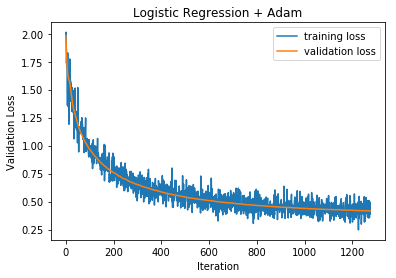

In [13]:
names = ['NAG', 'RMSprop', 'AdaDelta', 'Adam']
i = 3

plot.plot(loss_train[i], label="training loss")
plot.plot(loss_vali[i], label="validation loss")
plot.legend()
plot.xlabel("Iteration")
plot.ylabel("Validation Loss")
plot.title('Logistic Regression + ' + names[i])
plot.show()